In [37]:
import os
from os import path
from datetime import datetime, timedelta, date
import pytz

from igraph import *

import seaborn as sns
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.colors as clr
%matplotlib inline

In [68]:
title = "WKU"
base_folder = "./simulations/wku23"
sim_id = 165
sim_tz = "Asia/Shanghai"
time0 = 'Nov 20 2023 9:00AM'
time1 = 'Dec 4 2023 12:00PM'
time_step_min = 30
use_new_id_schema = True   

In [69]:
# Configuration

# Option colors:
# https://matplotlib.org/3.1.0/gallery/color/named_colors.html
option_color = {0: clr.to_hex("cornflowerblue"),  # Quarantine Yes
                1: clr.to_hex("darkorange"),      # Quarantine No
                2: clr.to_hex("darkorange"),      # 
                3: clr.to_hex("darkgrey"),        # 
                4: clr.to_hex("mediumseagreen"),  # 
                5: clr.to_hex("darkorchid")       # 
               } 

data_folder = path.join(base_folder, "data")
output_root = path.join(base_folder, "output")
output_folder = path.join(output_root, "behaviors")
if not path.exists(output_folder):
    os.makedirs(output_folder)

# Print warning messages to the console when parsing data
print_data_warnings = True

frame_format = "png"

# Time delta for plots in seconds
time_delta_sec = 60 * (60 * 24)

# https://howchoo.com/g/ywi5m2vkodk/working-with-datetime-objects-and-timezones-in-python
# https://itnext.io/working-with-timezone-and-python-using-pytz-library-4931e61e5152
timezone = pytz.timezone(sim_tz)

if time0 and time1:
    obs_date0 = timezone.localize(datetime.strptime(time0, '%b %d %Y %I:%M%p'))
    obs_date1 = timezone.localize(datetime.strptime(time1, '%b %d %Y %I:%M%p'))
else:
    obs_date0 = None
    obs_date1 = None

In [70]:
def get_modifiers_list(events):
    modifiers = events[(events["type"] == "modifier")]
    return modifiers

def get_score_events(events):
    scores = events[(events["type"] == "score")]
    return scores

def get_message_counts(events):
    msg1 = len(events[(events["modifier"] == "https://www.wkuoo23-simulation.info/psa-message-1")])
    msg2 = len(events[(events["modifier"] == "https://www.wkuoo23-simulation.info/psa-message-2")])
    return {"message_suggest_quarantine":msg1, "message_demand_quarantine":msg2}

def get_behavior_counts(events):
    nq = len(events[(events["inf"] == "quarantine")])
    nnq = len(events[(events["inf"] == "noQuarantine")])
    return {"quarantine_choice_yes":nq, "quarantine_choice_no":nnq}
    
# https://stackoverflow.com/a/48938464
def hour_rounder(t):
    # Rounds to nearest hour by adding a timedelta hour if minute >= 30
    return (t.replace(second=0, microsecond=0, minute=0, hour=t.hour)
               +timedelta(hours=t.minute//30))

In [80]:
# Load participants and histories

user_survey = pd.read_csv(path.join(data_folder, "survey.csv")) 
question1 = "Public health officials should have the power to order people into quarantine during COVID-19 outbreaks"
question2 = "If someone is given a quarantine order by a public health official, they should follow it no matter what else is going on in their life at work or home"
question3 = "If I go into quarantine, my family, friends, and community will be protected from getting COVID-19"

all_users = pd.read_csv(path.join(data_folder, "participants.csv")) 
all_events = pd.read_csv(path.join(data_folder, "histories.csv"))

users = all_users[all_users["sim_id"] == sim_id]

events = all_events[all_events["sim_id"] == sim_id]
events.fillna({'contact_length':0, 'peer_id':-1}, inplace=True)
events["event_start"] = events["time"] - events["contact_length"]/1000
events["event_start"] = events["event_start"].astype(int)

p2pToSim = pd.Series(users.sim_id.values, index=users.p2p_id).to_dict()
p2pToId = pd.Series(users.id.values, index=users.p2p_id).to_dict()
idTop2p = pd.Series(users.p2p_id.values, index=users.id).to_dict()

user_ids = []
uId2Id = {}
for rid, id in zip(list(users.random_id.values), list(users.id.values)):
    uid = str(rid).rjust(4, '0')
    user_ids.append(uid)
    uId2Id[uid] = id

user_index = {}
index_user = {}
idx = 0
for kid in idTop2p:
    user_index[kid] = idx
    index_user[idx] = kid
    idx += 1

# These should return the same value
print(len(users))
print(len(idTop2p))    
print(len(p2pToId))
print(len(user_index))

/var/folders/dl/6khbyrbx22vfbf2s_yjt1zx80000gs/T/ipykernel_83041/754287964.py:9: DtypeWarning: Columns (6,7,8,13) have mixed types. Specify dtype option on import or set low_memory=False.
  all_events = pd.read_csv(path.join(data_folder, "histories.csv"))


794
794
794
794


In [72]:
# Round min and max times to the hour
min_time = min(events['time'])
max_time = max(events['time'])
first_date = hour_rounder(datetime.fromtimestamp(min_time, tz=timezone))
last_date = hour_rounder(datetime.fromtimestamp(max_time, tz=timezone))
min_time = datetime.timestamp(first_date)
max_time = datetime.timestamp(last_date)

print("First event:", first_date)
print("Last event :", last_date)

if time0 and time1:
    print("Start time:", datetime.strptime(time0, '%b %d %Y %I:%M%p'))
    print("End time:", datetime.strptime(time1, '%b %d %Y %I:%M%p'))

print(first_date.tzinfo)

First event: 2023-11-19 15:00:00+08:00
Last event : 2023-12-05 16:00:00+08:00
Start time: 2023-11-20 09:00:00
End time: 2023-12-04 12:00:00
Asia/Shanghai


## QUARANTINE CHOICE OVER TIME

CREATING FRAMES...
FRAME 2023-11-21 09:00:00+08:00
2023-11-22 09:00:00+08:00
2023-11-23 09:00:00+08:00
2023-11-24 09:00:00+08:00
2023-11-25 09:00:00+08:00
2023-11-26 09:00:00+08:00
2023-11-27 09:00:00+08:00
2023-11-28 09:00:00+08:00
2023-11-29 09:00:00+08:00
2023-11-30 09:00:00+08:00
2023-12-01 09:00:00+08:00
2023-12-02 09:00:00+08:00
2023-12-03 09:00:00+08:00
2023-12-04 09:00:00+08:00
2023-12-05 09:00:00+08:00

DONE


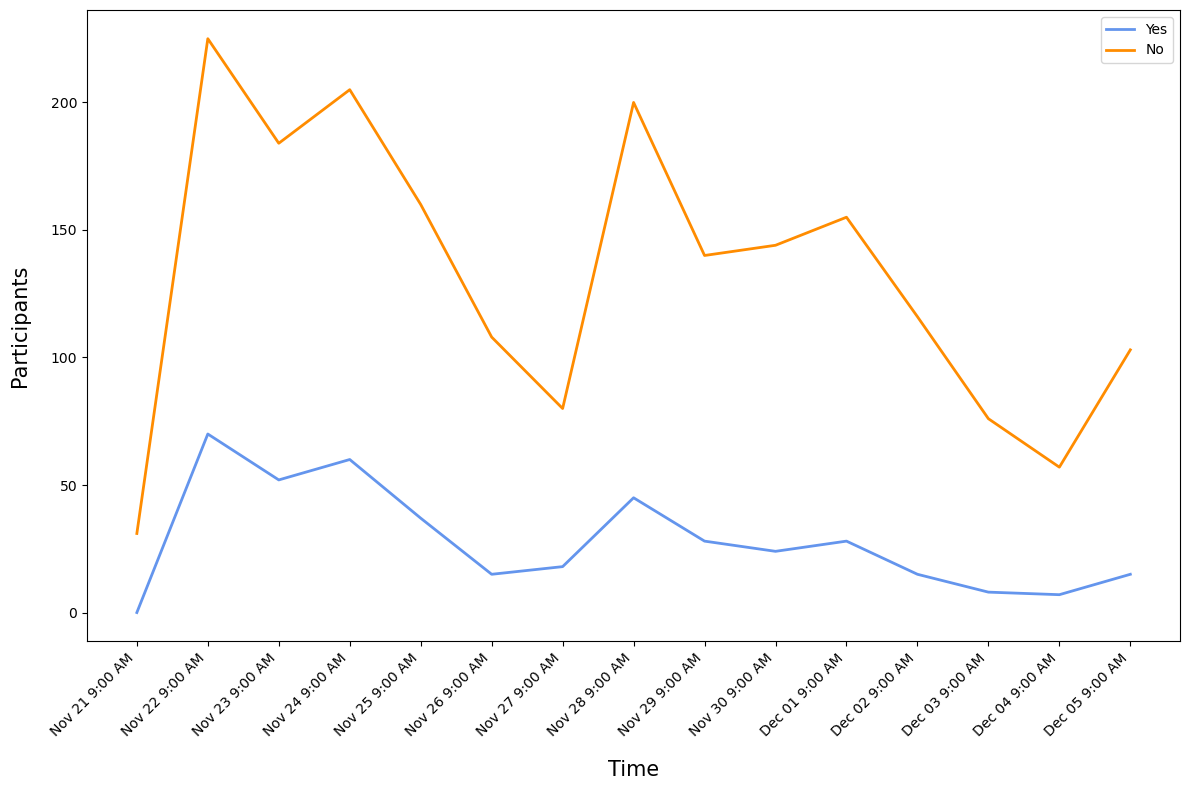

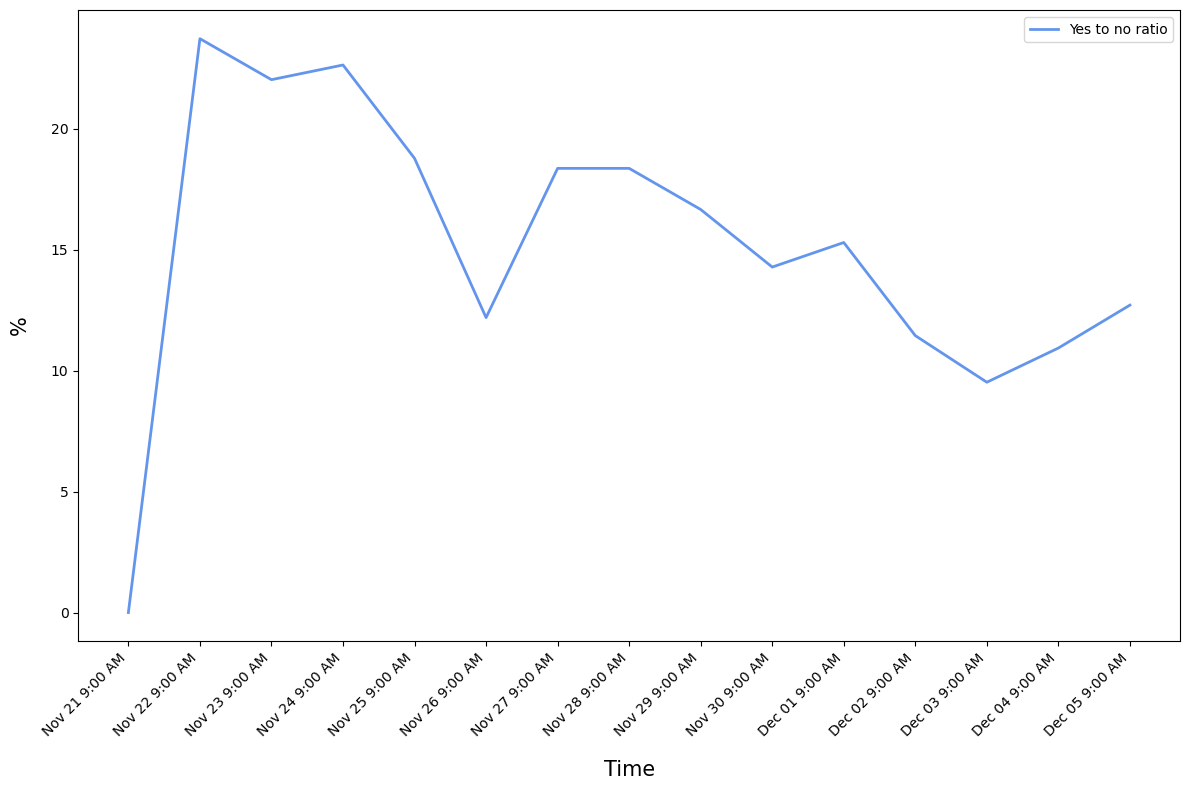

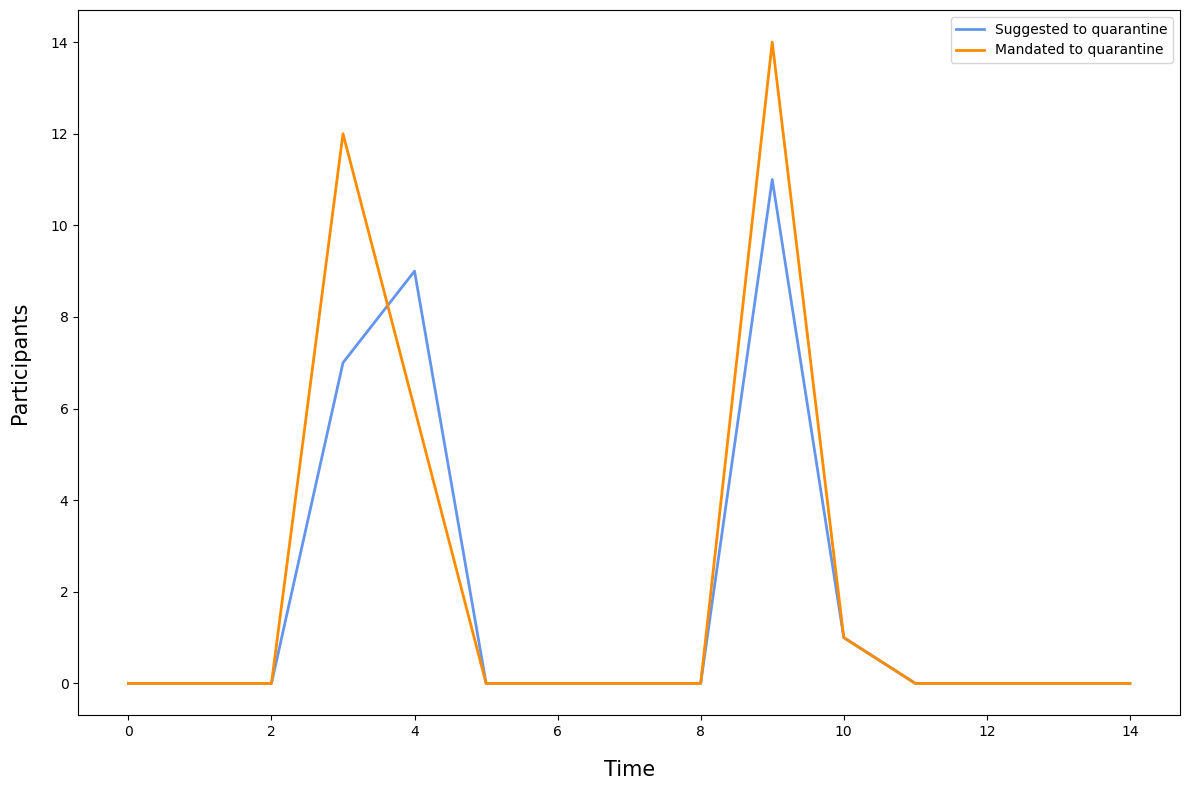

In [127]:
# Behaviors over time

print("CREATING FRAMES...") 

# How to properly animate an igraph network over time (so nodes change position smoothly from frame to frame):
# http://estebanmoro.org/post/2015-12-21-temporal-networks-with-r-and-igraph-updated/
# https://github.com/emoro/temporal_networks

frame = 0
layout0 = None
tstatus = None

if obs_date0 and obs_date1:
    tmin = datetime.timestamp(obs_date0)
    tmax = datetime.timestamp(obs_date1)
else:
    tmin = min_time
    tmax = max_time

series_quarantine_yes = []
series_quarantine_no = []
series_quarantine_ratio = []
series_message_suggest = []
series_message_demand = []

time_labels = []
time_ticks = []
time_index = []

t = tmin
print("FRAME", end =" ") 
while t <= tmax:
    t0 = t
    t += time_delta_sec
    td = datetime.fromtimestamp(t, tz=timezone)
    print(td)

    # We want to include events that ocurred between t0 and t
    condition = (t0 < events['time']) & (events['time'] <= t)

    tevents = events[condition]
    modifiers = get_modifiers_list(tevents)
    score_events = get_score_events(tevents)

    messages = get_message_counts(modifiers)
    behaviors = get_behavior_counts(score_events)

    time_index.append(frame)
    time_labels.append(td.strftime('%b %d %-I:%M %p'))
    time_ticks.append(frame)

    series_message_suggest.append(messages['message_suggest_quarantine'])
    series_message_demand.append(messages['message_demand_quarantine'])

    q_yes = behaviors['quarantine_choice_yes']
    q_no = behaviors['quarantine_choice_no']
    q_total = q_yes + q_no
    
    series_quarantine_yes.append(q_yes)
    series_quarantine_no.append(q_no)

    series_quarantine_ratio.append(100 * float(q_yes) / q_total)

    frame += 1

print("\nDONE")

# Quarantine yes/no plot
fig, ax = plt.subplots(figsize=(12,8), facecolor="white")      
plt.xlabel("Time", labelpad=15, fontsize=15)
plt.ylabel("Participants", labelpad=15, fontsize=15)
ax.plot(time_index, series_quarantine_yes, label="Yes", color=option_color[0], lw=2)
ax.plot(time_index, series_quarantine_no, label="No", color=option_color[1], lw=2)
plt.xticks(time_ticks, time_labels, rotation=45, horizontalalignment="right")
plt.legend(loc='upper right')
plt.tight_layout()
img_fn = "quarantine_choice_counts." + frame_format
# fig.savefig(os.path.join(output_folder, img_fn))
# plt.close('all')

# Quarantine yes/no ratio plot
fig, ax = plt.subplots(figsize=(12,8), facecolor="white")     
plt.xlabel("Time", labelpad=15, fontsize=15)
plt.ylabel("%", labelpad=15, fontsize=15)
ax.plot(time_index, series_quarantine_ratio, label="Yes to no ratio", color=option_color[0], lw=2)
plt.xticks(time_ticks, time_labels, rotation=45, horizontalalignment="right")
plt.legend(loc='upper right')
plt.tight_layout()
img_fn = "quarantine_choice_ratio." + frame_format
# fig.savefig(os.path.join(output_folder, img_fn))
# plt.close('all')

# Quarantine message received plot
fig, ax = plt.subplots(figsize=(12,8), facecolor="white")     
plt.xlabel("Time", labelpad=15, fontsize=15)
plt.ylabel("Participants", labelpad=15, fontsize=15)
ax.plot(time_index, series_message_suggest, label="Suggested to quarantine", color=option_color[0], lw=2)
ax.plot(time_index, series_message_demand, label="Mandated to quarantine", color=option_color[1], lw=2)
plt.legend(loc='upper right')
plt.tight_layout()
# img_fn = "quarantine_message_counts." + frame_format
# fig.savefig(os.path.join(output_folder, img_fn))
# plt.close('all')

## CORRELATION BETWEEN SURVEY RESPONSE AND QUARANTINE CHOICE

In [97]:
q1_scores = []
q2_scores = []
q3_scores = []
qCounts = []
noqCounts = []

for idx in user_survey.index:
    uid = user_survey["user_id"][idx]
    if uid in user_ids:
        id = uId2Id[uid]
        q1_score = user_survey["question1"][idx]
        q2_score = user_survey["question2"][idx]
        q3_score = user_survey["question3"][idx]

        qCond = (events["user_id"] == id) & (events["type"] == "score") & (events["inf"] == "quarantine")
        qEvents = events[qCond]
        qCount = len(qEvents)

        noqCond = (events["user_id"] == id) & (events["type"] == "score") & (events["inf"] == "noQuarantine")
        noqEvents = events[noqCond]
        noqCount = len(noqEvents)

        q1_scores.append(q1_score)
        q2_scores.append(q2_score)
        q3_scores.append(q3_score)
        qCounts.append(qCount)
        noqCounts.append(noqCount)

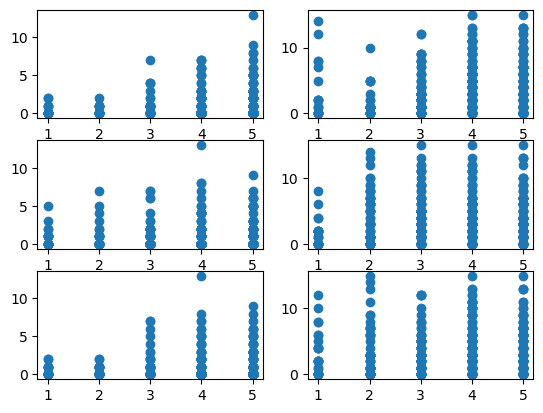

In [114]:
# Q1 = "Public health officials should have the power to order people into quarantine during COVID-19 outbreaks"
# Q2 = "If someone is given a quarantine order by a public health official, they should follow it no matter what else is going on in their life at work or home"
# Q3 = "If I go into quarantine, my family, friends, and community will be protected from getting COVID-19"

fig, axs = plt.subplots(3, 2)
axs[0, 0].scatter(q1_scores, qCounts)
axs[0, 1].scatter(q1_scores, noqCounts)
axs[1, 0].scatter(q2_scores, qCounts)
axs[1, 1].scatter(q2_scores, noqCounts)
axs[2, 0].scatter(q3_scores, qCounts)
axs[2, 1].scatter(q3_scores, noqCounts)

<Axes: >

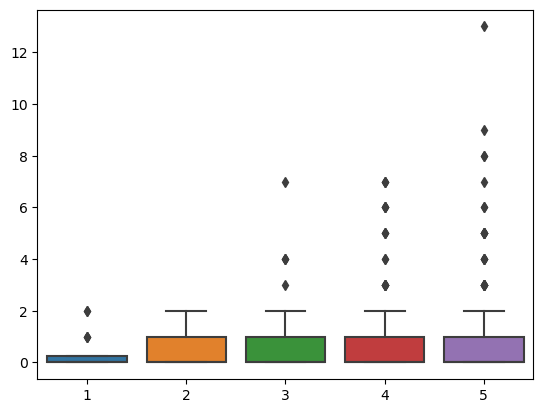

In [117]:
# sns.violinplot(x=q1_scores, y=qCounts, bw_adjust=.5, inner="stick")
sns.boxplot(x=q1_scores, y=qCounts)

<Axes: >

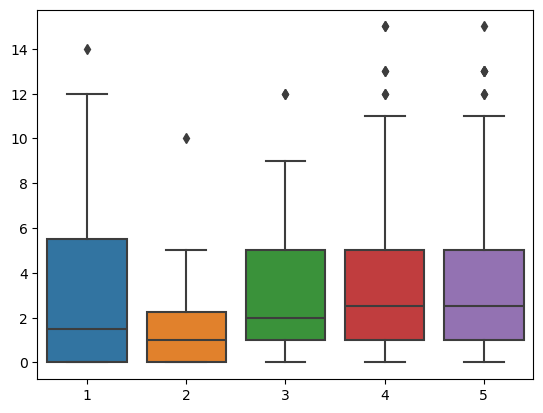

In [116]:
# sns.violinplot(x=q1_scores, y=noqCounts, bw_adjust=.5, inner="stick")
sns.boxplot(x=q1_scores, y=noqCounts)

<Axes: >

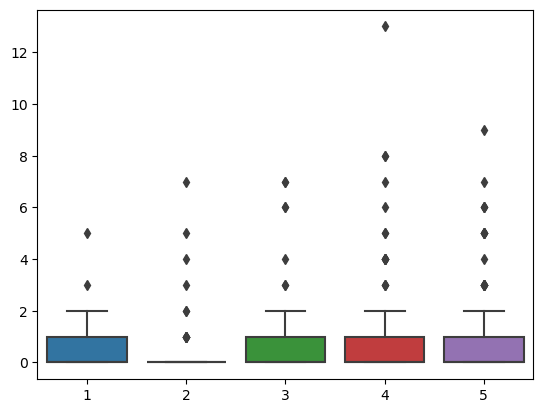

In [118]:
# sns.violinplot(x=q2_scores, y=qCounts, bw_adjust=.5, inner="stick")
sns.boxplot(x=q2_scores, y=qCounts)

<Axes: >

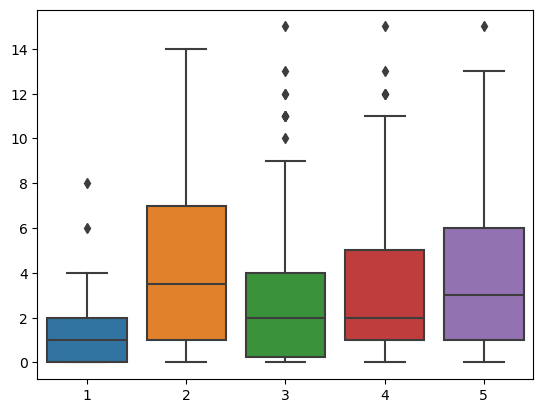

In [119]:
# sns.violinplot(x=q2_scores, y=noqCounts, bw_adjust=.5, inner="stick")
sns.boxplot(x=q2_scores, y=noqCounts)

<Axes: >

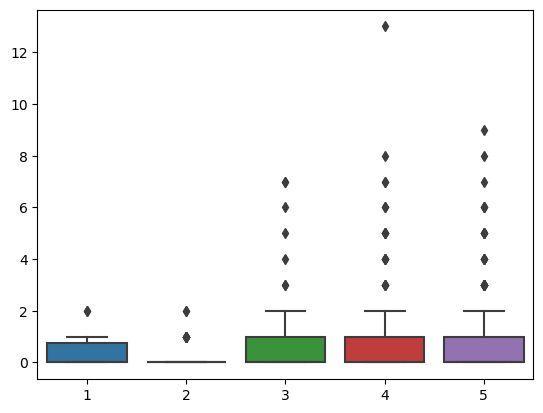

In [120]:
# sns.violinplot(x=q3_scores, y=qCounts, bw_adjust=.5, inner="stick")
sns.boxplot(x=q3_scores, y=qCounts)

<Axes: >

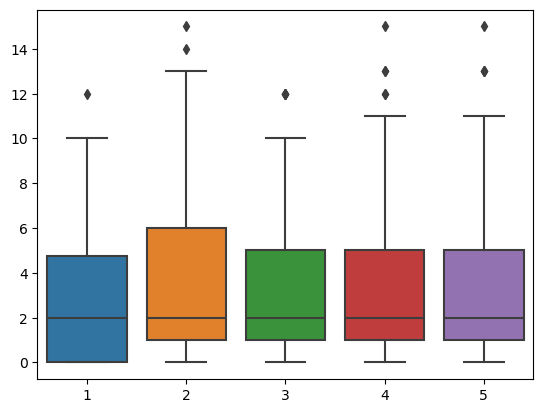

In [121]:
# sns.violinplot(x=q3_scores, y=noqCounts, bw_adjust=.5, inner="stick")
sns.boxplot(x=q3_scores, y=noqCounts)

<Axes: >

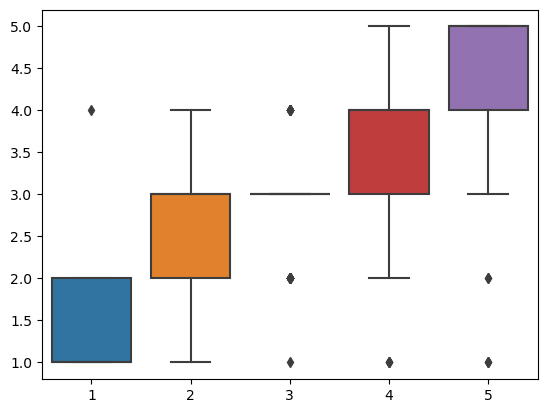

In [122]:
sns.boxplot(x=q1_scores, y=q2_scores)

<Axes: >

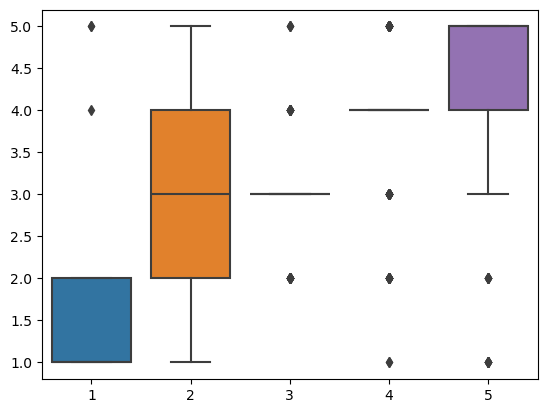

In [123]:
sns.boxplot(x=q1_scores, y=q3_scores)

<Axes: >

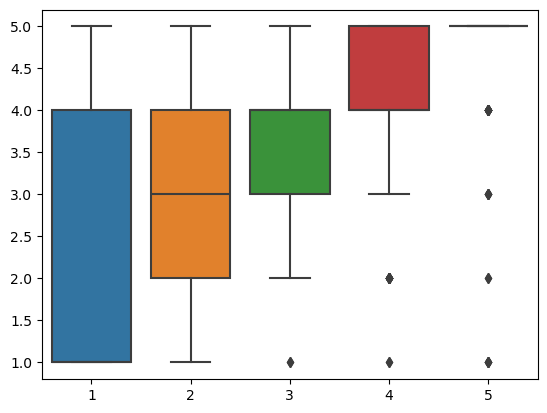

In [124]:
sns.boxplot(x=q2_scores, y=q3_scores)

## CORRELATION BETWEEN MESSAGING AND QUARANTINE CHOICE

In [163]:
# First PSA message: Thursday, November 23, 2023 6:08:13 PM (Shanghai time)
# timestamp: 1700784493

# End of first week: Friday 11/25 9 PM (Shanghai time)
# timestap: 1700917200

# Start of second week: Monday 11/27 9 AM (Shanghai time)
# timestamp: 1701046800

# Second PSA message: Tuesday, November 28, 2023 10:38:45 PM (Shanghai time)
# timestamp: 1701232725

# End of second week: Thursday 11/30 9 PM (Shanghai time)
# timestap: 1701349200

def calculate_counts_before_after(events, timestamp):
    q1_events = events[(events["type"] == "modifier") & (events["modifier"] == "https://www.wkuoo23-simulation.info/psa-message-1")]
    q2_events = events[(events["type"] == "modifier") & (events["modifier"] == "https://www.wkuoo23-simulation.info/psa-message-2")]    
    q1_users = list(q1_events["user_id"])
    q2_users = list(q2_events["user_id"])

    q1_before_counts = []
    q2_before_counts = []
    before_msg_events = events[events["time"] < timestamp]
    for id in q1_users:    
        qCount = len(before_msg_events[(before_msg_events["user_id"] == id) & (before_msg_events["type"] == "score") & (before_msg_events["inf"] == "quarantine")])
        q1_before_counts.append(qCount)
    for id in q2_users:  
        qCount = len(before_msg_events[(before_msg_events["user_id"] == id) & (before_msg_events["type"] == "score") & (before_msg_events["inf"] == "quarantine")])
        q2_before_counts.append(qCount)    

    q1_after_counts = []
    q2_after_counts = []
    after_msg_events = events[timestamp < events["time"]]
    for id in q1_users:
        qCount = len(after_msg_events[(after_msg_events["user_id"] == id) & (after_msg_events["type"] == "score") & (after_msg_events["inf"] == "quarantine")])
        q1_after_counts.append(qCount)
    for id in q2_users:
        qCount = len(after_msg_events[(after_msg_events["user_id"] == id) & (after_msg_events["type"] == "score") & (after_msg_events["inf"] == "quarantine")])
        q2_after_counts.append(qCount)
    
    return {"before_m1": q1_before_counts, "after_m1": q1_after_counts, "before_m2": q2_before_counts, "after_m2": q2_after_counts}
    

week1_events = events[(events["time"] < 1700917200)]
week2_events = events[(1701046800 < events["time"]) & (events["time"] < 1701349200)]

res_week1 = calculate_counts_before_after(week1_events, 1700784493)
res_week2 = calculate_counts_before_after(week2_events, 1701232725)


before_msg1 = res_week1["before_m1"] + res_week2["before_m1"]
after_msg1 = res_week1["after_m1"] + res_week2["after_m1"]

before_msg2 = res_week1["before_m2"] + res_week2["before_m2"]
after_msg2 = res_week1["after_m2"] + res_week2["after_m2"]

dict_msg1 = {'quarantine': before_msg1 + after_msg1, 'message': ["before"] * len(before_msg1) + ["after"] * len(after_msg1)} 
df_msg1 = pd.DataFrame(dict_msg1)

dict_msg2 = {'quarantine': before_msg2 + after_msg2, 'message': ["before"] * len(before_msg2) + ["after"] * len(after_msg2)} 
df_msg2 = pd.DataFrame(dict_msg2)

<Axes: xlabel='quarantine', ylabel='message'>

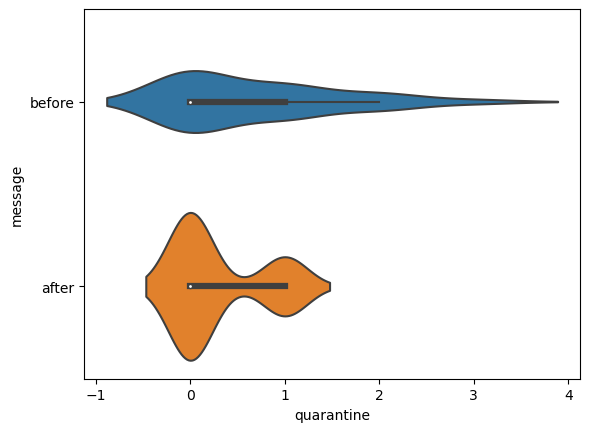

In [183]:
sns.violinplot(data=df_msg1, x="quarantine", y="message")

<Axes: xlabel='quarantine', ylabel='message'>

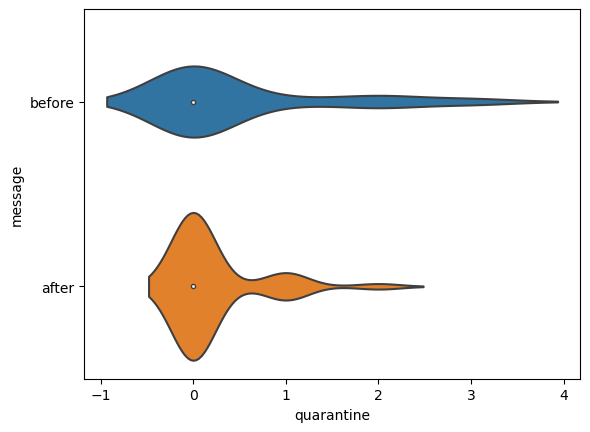

In [184]:
sns.violinplot(data=df_msg2, x="quarantine", y="message")

In [193]:
mean_before1 = df_msg1[df_msg1["message"] == "before"]["quarantine"].mean()
mean_after1 = df_msg1[df_msg1["message"] == "after"]["quarantine"].mean()
print(mean_before1)
print(mean_after1)
print(mean_after1/mean_before1)

0.6785714285714286
0.2857142857142857
0.42105263157894735


In [192]:
mean_before2 = df_msg2[df_msg2["message"] == "before"]["quarantine"].mean()
mean_after2 = df_msg2[df_msg2["message"] == "after"]["quarantine"].mean()
print(mean_before2)
print(mean_after2)
print(mean_after2/mean_before2)

0.48484848484848486
0.21212121212121213
0.4375
